In [1]:
import os, ccdproc
from os import listdir
import numpy as np
import pandas as pd
from pathlib import Path
from utils.correcting import Correcting
from utils.plate_solving import platesolving
from utils.photometry import Photometry
import matplotlib.pyplot as plt
from scipy import optimize

#For isochrones
import read_mist_models # a .py file that needs to be inyour directory like A345_utilities.py

Plate Solving module - Ignore any API key warnings below, they are not important



Get photometry files:

In [2]:
target = "M35"
size = "3000x3000"

# Specify the platesolved image output path
Input_directory = '/data/observatory/student_data/Alasdairs File/Output_Files/Cluster Photometry/M35/'

# Specify the platesolved image output path
#Output_directory = 'examples/a345/lab_projects/shared-data/student_data/Alasdairs File/Output_Files'

# folderpath = os.path.join(Input_directory)
folderpath = Input_directory

In [3]:


folderpathR = f'/data/observatory/student_data/natalia_bajnokova/{target}/Calibrated_{size}/R/'
folderpathG = f'/data/observatory/student_data/natalia_bajnokova/{target}/Calibrated_{size}/G/'
folderpathI = f'/data/observatory/student_data/natalia_bajnokova/{target}/Calibrated_{size}/I/'


filenames = [folderpathR+f for f in listdir(folderpathR) if f.endswith('.dat')]
filenames+=[folderpathG+f for f in listdir(folderpathG) if f.endswith('.dat')]
filenames+=[folderpathI+f for f in listdir(folderpathI) if f.endswith('.dat')]
filenames.sort()

stars = {}
for file in filenames:
    table = np.genfromtxt(file, names=True,dtype=None)
    path = Path(file)
    filtr = str(path.parent)[-1] #Get filter
    stars = Photometry.stars_list(table, stars, filtr)

In [4]:
diction = {"ra_unrounded": [], "dec_unrounded": [], "ra":[], "dec": [], "Imag_found":[], "Gmag_found":[], "Rmag_found":[], 
           "Imag_full":[], "Gmag_full":[], "Rmag_full":[], "I_flux": [], "G_flux":[], "R_flux":[]}



for obj in stars.values():
    diction["ra_unrounded"].append(np.round(obj.ra, 4))
    diction["dec_unrounded"].append(np.round(obj.dec, 4))
    diction["ra"].append(np.round(obj.ra, 3))
    diction["dec"].append(np.round(obj.dec, 3))
    diction["Imag_found"].append(-2.5*np.log10(obj.i.avg_flux*1.3))
    diction["Gmag_found"].append(-2.5*np.log10(obj.g.avg_flux*1.3))
    diction["Rmag_found"].append(-2.5*np.log10(obj.r.avg_flux*1.3))
    diction["Imag_full"].append([i for i in obj.i.mag])
    diction["Gmag_full"].append([i for i in obj.g.mag])
    diction["Rmag_full"].append([i for i in obj.r.mag])
    diction["I_flux"].append(obj.i.avg_flux*1.3)
    diction["G_flux"].append(obj.g.avg_flux*1.3)
    diction["R_flux"].append(obj.r.avg_flux*1.3)


i_flux = []
g_flux= []
r_flux = []
for obj in stars.values(): 

    i_flux.append(obj.i.avg_flux*1.3)
    g_flux.append(obj.g.avg_flux*1.3)
    r_flux.append(obj.r.avg_flux*1.3)

<ipython-input-4-4ac3b5447a43>:11: RuntimeWarning: invalid value encountered in log10
  diction["Imag_found"].append(-2.5*np.log10(obj.i.avg_flux*1.3))
<ipython-input-4-4ac3b5447a43>:13: RuntimeWarning: divide by zero encountered in log10
  diction["Rmag_found"].append(-2.5*np.log10(obj.r.avg_flux*1.3))
<ipython-input-4-4ac3b5447a43>:11: RuntimeWarning: divide by zero encountered in log10
  diction["Imag_found"].append(-2.5*np.log10(obj.i.avg_flux*1.3))
<ipython-input-4-4ac3b5447a43>:13: RuntimeWarning: invalid value encountered in log10
  diction["Rmag_found"].append(-2.5*np.log10(obj.r.avg_flux*1.3))
<ipython-input-4-4ac3b5447a43>:12: RuntimeWarning: invalid value encountered in log10
  diction["Gmag_found"].append(-2.5*np.log10(obj.g.avg_flux*1.3))
<ipython-input-4-4ac3b5447a43>:12: RuntimeWarning: divide by zero encountered in log10
  diction["Gmag_found"].append(-2.5*np.log10(obj.g.avg_flux*1.3))


In [5]:
calibration_file = '/data/observatory/student_data/Alasdairs File/M35_Calibration_Star_List.csv'

#col_names=['Full', 'RAJ2000 deg', 'DEJ2000 deg', 'VTmag mag', "gmag mag", "rmag mag", "imag mag", "ok"]
calibstar_all = pd.read_csv(calibration_file)
calibstar_all = calibstar_all.round({'RAJ2000': 3, 'DEJ2000': 3})

#calibstars = calibstar_all.loc[calibstar_all['ok'] == 1]
calibstars =calibstar_all.round({'RAJ2000': 3, 'DEJ2000': 3})

In [6]:
platesovled_stars = pd.DataFrame(data = diction)
platesovled_stars['index_col'] = platesovled_stars.index

import pprint

merged = pd.merge(calibstar_all, platesovled_stars, how='inner', left_on=['RAJ2000', 'DEJ2000'], right_on=['ra', 'dec'])
merged_correct = merged.drop(index=[32,50])
outlier = merged.iloc[[50, 32]]

pp = pprint.PrettyPrinter(width=41, compact=True)
pp.pprint(calibstars)
#pp.pprint(merged)

      Id  RAJ2000  DEJ2000  VTmag   gmag   rmag   imag  ok
0      1   92.222   23.808   9.85   9.95   9.71   9.70   1
1      2   92.179   23.858  10.68  10.79  10.62  10.62   1
2      3   92.046   23.861   8.24   8.20   8.43   8.59   1
3      4   92.407   23.872  10.12  10.12  10.26  10.40   1
4      5   92.256   23.873  10.52  10.91   9.78   9.36   1
..   ...      ...      ...    ...    ...    ...    ...  ..
195  196   92.225   24.656  11.40  11.79  10.62  10.20   0
196  197   92.416   24.661  11.89  12.01  12.08  12.18   0
197  198   92.294   24.683  10.89  11.13  11.20  11.30   1
198  199   92.281   24.687  10.52  10.52  10.60  10.74   1
199  200   92.346   24.693  11.50  11.67  11.13  10.96   1

[200 rows x 8 columns]


In [7]:
def linear (x, m, k):
    return (m*x + k)

def get_range(array):
    a_range = np.linspace(np.min(array), np.max(array), 1000)
    return a_range

r_params, r_params_covariance = optimize.curve_fit(linear, merged["Rmag_found"], merged["rmag"])
r_m = r_params[0]
r_k = r_params[1]
r_m_e = np.sqrt(np.diag(r_params_covariance))[0]
r_k_e = np.sqrt(np.diag(r_params_covariance))[1]



g_params, g_params_covariance = optimize.curve_fit(linear, merged["Gmag_found"], merged["gmag"])
g_m = g_params[0]
g_k = g_params[1]
g_m_e = np.sqrt(np.diag(g_params_covariance))[0]
g_k_e = np.sqrt(np.diag(g_params_covariance))[1]


i_params, i_params_covariance = optimize.curve_fit(linear, merged["Imag_found"], merged["imag"])
i_m = i_params[0]
i_k = i_params[1]
i_m_e = np.sqrt(np.diag(i_params_covariance))[0]
i_k_e = np.sqrt(np.diag(i_params_covariance))[1]

print (i_m)
print (i_k)

print (i_m_e)
print (i_k_e)

0.8917307526055639
17.413118748186232
0.01975903031713849
0.14197482807514591


In [8]:
I_corrected = []
class Corrected:
    def __init__(self, real):
        self.real = real
        self.mag = []
        self.corrected_var = []
        self.residual_var = []
    def add(self, mag):
        self.mag.append(mag)
        self.residual_var.append([i - self.real for i in mag])
        
    def corrected_residual(self,v):
        
        self.corrected_var.append(v)
        
        
        

I_corrected = []
for index, row in merged_correct.iterrows():
    a = Corrected(row["imag"])
    a.add([i_m*e + i_k for e in row["Imag_full"]])
    I_corrected.append(a)

Img = np.array([])

for row in I_corrected:
   
    if Img.size == 0:
        Img = np.append(Img, row.residual_var[0])
        
    else:
        Img = np.vstack((Img, row.residual_var[0]))

    
    
r = [np.mean(Img[:,i]) for i in range(len(Img[0]))]

for i in range(len(r)):
    var = r[i]
    for row in I_corrected:
        v = row.mag[0][i] - var
        row.corrected_residual(v)
    
stds = [np.std(I_corrected[i].corrected_var)*5 for i in range(len(I_corrected))]

#Outliers stds
I_outliers = []
for index, row in outlier.iterrows():
    a = Corrected(row["imag"])
    a.add([i_m*e + i_k for e in row["Imag_full"]])
    I_outliers.append(a)
    
Img_outliers = np.array([])

for row in I_outliers:
   
    if Img_outliers.size == 0:
        Img_outliers = np.append(Img_outliers, row.residual_var[0])
        
    else:
        Img_outliers = np.vstack((Img_outliers, row.residual_var[0]))

    
print (Img_outliers)
r_outliers = [np.mean(Img_outliers[:,i]) for i in range(len(Img_outliers[0]))]

for i in range(len(r_outliers)):
    var = r_outliers[i]
    for row in I_outliers:
        v = row.mag[0][i] - var
        row.corrected_residual(v)
    
stds_outliers = [np.std(I_outliers[i].corrected_var)*8 for i in range(len(I_outliers))]

[[-0.67691136 -0.61493175 -0.52391242 -0.36773553 -0.25852231 -0.15638789
  -0.10517422  0.03344957 -0.10938233 -0.1762904  -0.3148278  -0.42504226
  -0.378595   -0.43694958 -0.49845008 -0.43571974 -0.27136301 -0.21143793
  -0.23494337 -0.17322775]
 [ 0.25832247  0.31644556  0.40020844  0.56269303  0.6786445   0.81014695
   0.83922078  0.94416021  0.82822323  0.74866684  0.61053721  0.50387292
   0.54412003  0.49078106  0.43362424  0.49523585  0.65839565  0.72094283
   0.69202461  0.75246487]]


In [9]:
g_error_calib = (1.0857/np.sqrt(merged_correct["G_flux"])) 
r_error_calib = (1.0857/np.sqrt(merged_correct["R_flux"]))
i_error_calib = (1.0857/np.sqrt(merged_correct["I_flux"]))

i_error_outlier = (1.0857/np.sqrt(outlier["I_flux"])) 

stds_new = [np.std(i.mag)*0.5 for i in I_corrected]
print (stds_new)

[0.09028466592326641, 0.09107069444938305, 0.09087272434810696, 0.08999139978094918, 0.09000451794053808, 0.08954497955746742, 0.09027593744988341, 0.09063168198543985, 0.09025640529833034, 0.09006759156540556, 0.08991686445482121, 0.08940989033169418, 0.08971631691804403, 0.09007322166915374, 0.08819086541319263, 0.09069410798343175, 0.0910343242829531, 0.08687453518874831, 0.08977586691195293, 0.09042091848748117, 0.0887913902860269, 0.09030272521704714, 0.09011759628742229, 0.08933095273492114, 0.09105959606881157, 0.0895858026360034, 0.09014601491679305, 0.09074594511169162, 0.09050029356266152, 0.08978791775749606, 0.09057313757087401, 0.08977170985953627, 0.08908620941293496, 0.09022826924915033, 0.0902397082954099, 0.0900344770877304, 0.09031515422382645, 0.08949463571057907, 0.08961958417715567, 0.09026943857916525, 0.09031222122032469, 0.08952864254616262, 0.089929927187646, 0.08988363808773868, 0.09093685305264627, 0.09002234690372055, 0.090288356083144, 0.08928396208276529, 

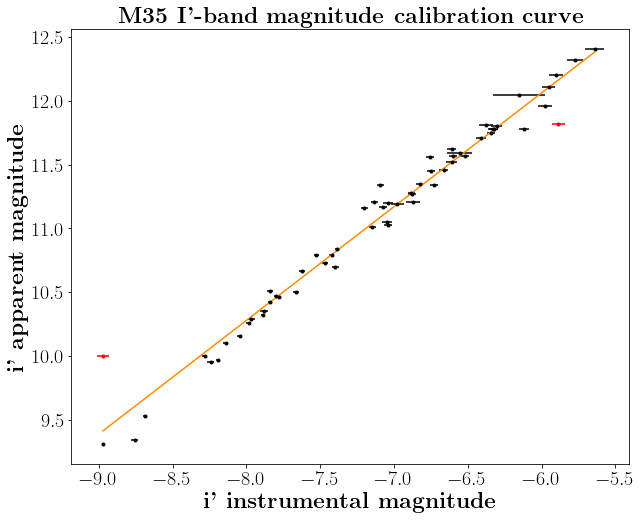

In [11]:
plt.figure(figsize=[10,8])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=23)     # fontsize of the axes title
plt.rc('axes', labelsize=23)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=23)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.plot(get_range(merged["Imag_found"]), linear(get_range(merged["Imag_found"]), i_m, i_k), "darkorange")
plt.errorbar(outlier["Imag_found"], outlier["imag"],  xerr = stds_outliers, fmt=".", mec='red', mfc='red', ecolor="red")
plt.errorbar(merged_correct["Imag_found"], merged_correct["imag"], xerr = stds, fmt="k.")

plt.title(r"\textbf{M35 I'-band magnitude calibration curve}")
plt.ylabel(r"\textbf{i' apparent magnitude}")
plt.xlabel(r"\textbf{i' instrumental magnitude}")
plt.savefig("M35_calibration_curve.png")

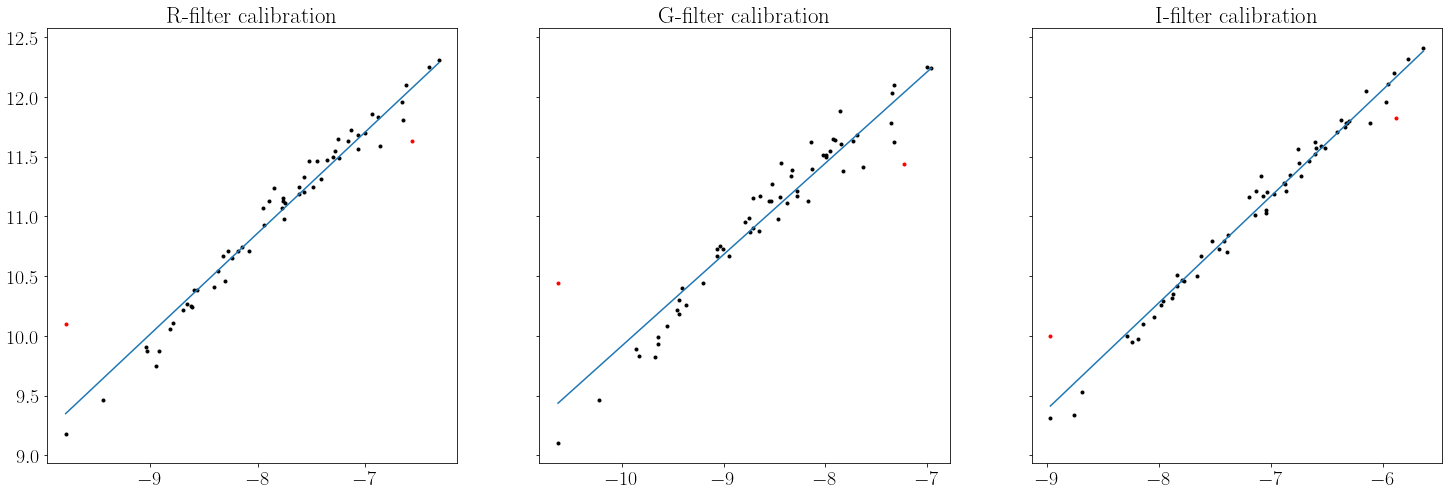

In [12]:
f, (ax_r, ax_g, ax_i) = plt.subplots(1, 3, sharey=True, figsize=(25,8))
ax_r.plot(outlier["Rmag_found"], outlier["rmag"],  "r.")
ax_r.plot(merged_correct["Rmag_found"], merged_correct["rmag"], "k.")
ax_r.plot(get_range(merged_correct["Rmag_found"]), linear(get_range(merged_correct["Rmag_found"]), r_m, r_k))

ax_g.plot(outlier["Gmag_found"], outlier["gmag"],  "r.")
ax_g.plot(merged_correct["Gmag_found"], merged_correct["gmag"],  "k.")
ax_g.plot(get_range(merged_correct["Gmag_found"]), linear(get_range(merged_correct["Gmag_found"]), g_m, g_k))

ax_i.plot(outlier["Imag_found"], outlier["imag"],  "r.")
ax_i.plot(merged_correct["Imag_found"], merged_correct["imag"], "k.")
ax_i.plot(get_range(merged_correct["Imag_found"]), linear(get_range(merged_correct["Imag_found"]), i_m, i_k))

ax_r.set_title("R-filter calibration")
ax_g.set_title("G-filter calibration")
ax_i.set_title("I-filter calibration")
plt.show()

In [13]:
g_mag_uncorrected = -2.5*np.log10(g_flux)
r_mag_uncorrected = -2.5*np.log10(r_flux)
i_mag_uncorrected = -2.5*np.log10(i_flux)

g_mag_corrected = linear(g_mag_uncorrected, g_m, g_k)
i_mag_corrected = linear(i_mag_uncorrected, i_m, i_k)
r_mag_corrected = linear(r_mag_uncorrected, r_m, r_k)

g_mag_callibration = linear(merged_correct["Gmag_found"], g_m, g_k)
i_mag_callibration = linear(merged_correct["Imag_found"], i_m, i_k)
r_mag_callibration = linear(merged_correct["Rmag_found"], r_m, r_k)

gi = np.subtract(g_mag_corrected,i_mag_corrected)
gr = np.subtract(g_mag_corrected,r_mag_corrected)
ri = np.subtract(r_mag_corrected,i_mag_corrected)

gi_callibration = np.subtract(g_mag_callibration,i_mag_callibration)
gr_callibration = np.subtract(g_mag_callibration,r_mag_callibration)
ri_callibration = np.subtract(r_mag_callibration,i_mag_callibration)

<ipython-input-13-ca5a47a4ecba>:1: RuntimeWarning: divide by zero encountered in log10
  g_mag_uncorrected = -2.5*np.log10(g_flux)
<ipython-input-13-ca5a47a4ecba>:1: RuntimeWarning: invalid value encountered in log10
  g_mag_uncorrected = -2.5*np.log10(g_flux)
<ipython-input-13-ca5a47a4ecba>:2: RuntimeWarning: divide by zero encountered in log10
  r_mag_uncorrected = -2.5*np.log10(r_flux)
<ipython-input-13-ca5a47a4ecba>:2: RuntimeWarning: invalid value encountered in log10
  r_mag_uncorrected = -2.5*np.log10(r_flux)
<ipython-input-13-ca5a47a4ecba>:3: RuntimeWarning: divide by zero encountered in log10
  i_mag_uncorrected = -2.5*np.log10(i_flux)
<ipython-input-13-ca5a47a4ecba>:3: RuntimeWarning: invalid value encountered in log10
  i_mag_uncorrected = -2.5*np.log10(i_flux)
<ipython-input-13-ca5a47a4ecba>:13: RuntimeWarning: invalid value encountered in subtract
  gi = np.subtract(g_mag_corrected,i_mag_corrected)
<ipython-input-13-ca5a47a4ecba>:14: RuntimeWarning: invalid value encounter

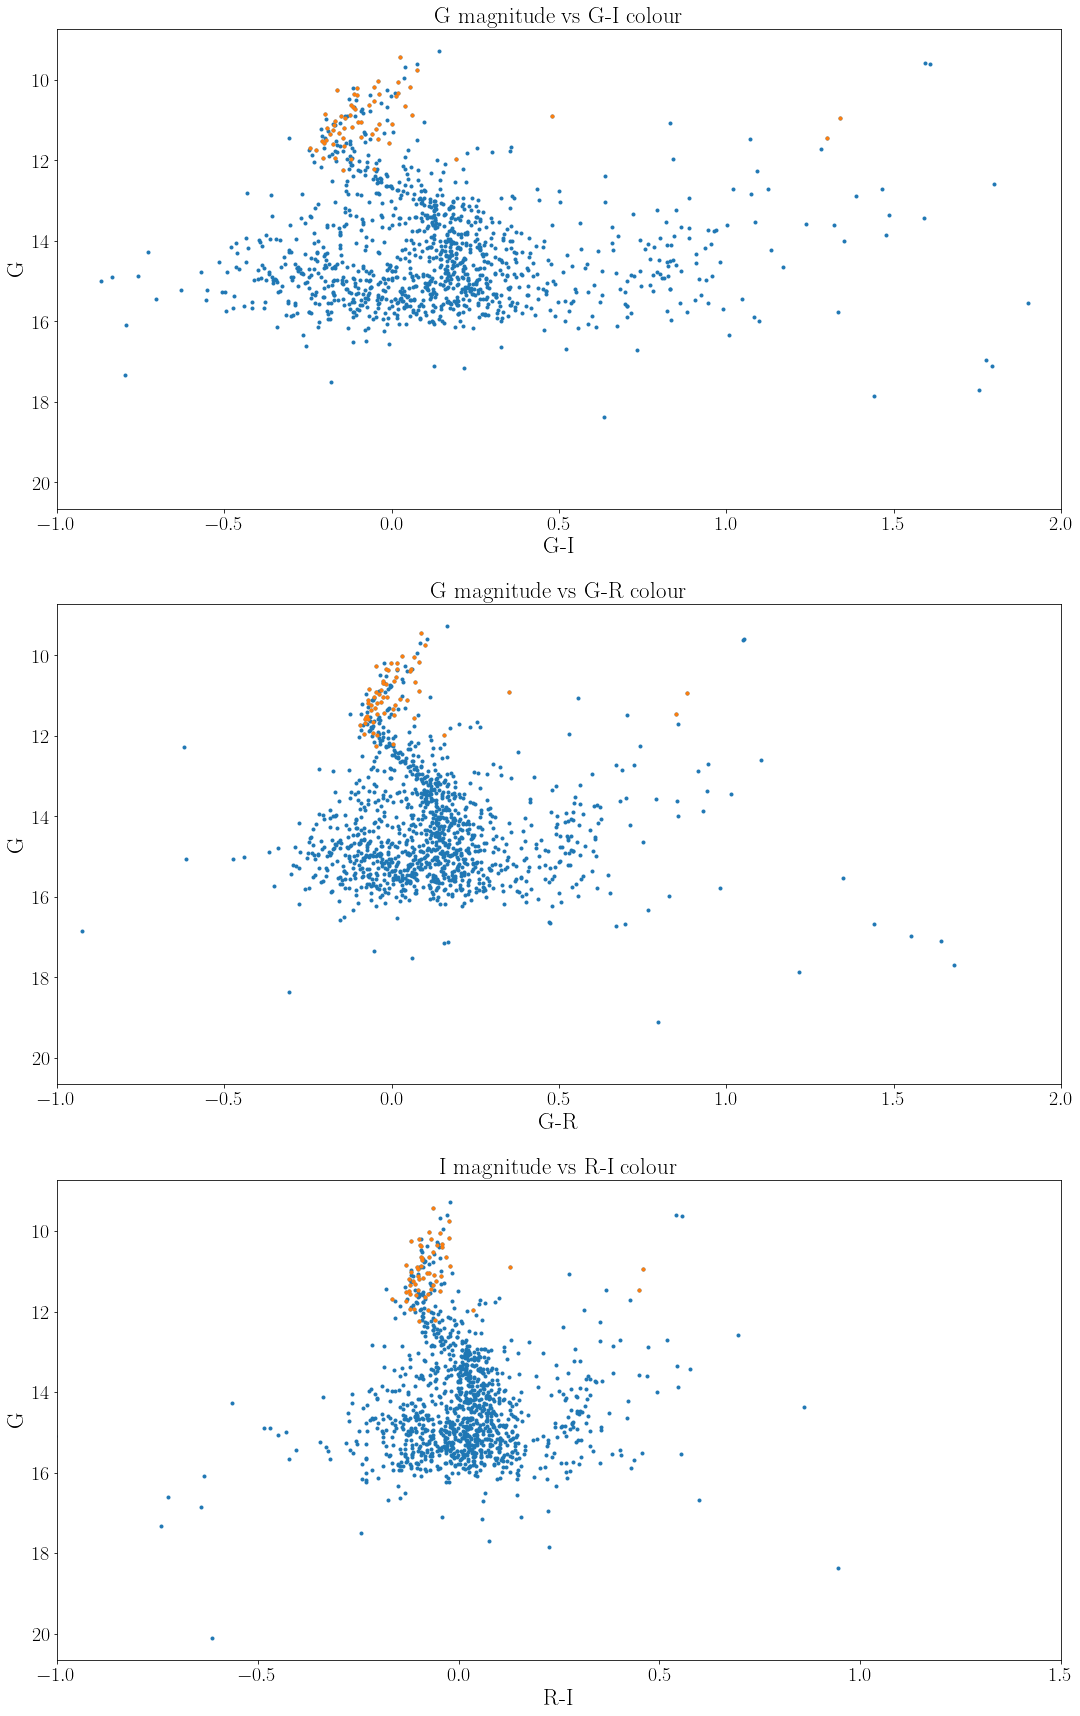

In [14]:
plt.figure(figsize=[18,30])
plt.subplot(311)
plt.plot(gi, g_mag_corrected, ".")
plt.plot(gi_callibration, g_mag_callibration, ".")
plt.plot()
plt.xlim([-1, 2])
plt.xlabel("G-I")
plt.ylabel("G")
plt.title("G magnitude vs G-I colour")
plt.gca().invert_yaxis()

plt.subplot(312)
plt.plot(gr, g_mag_corrected, ".")
plt.plot(gr_callibration, g_mag_callibration, ".")
plt.xlabel("G-R")
plt.ylabel("G")
plt.xlim([-1, 2])
plt.title("G magnitude vs G-R colour")
plt.gca().invert_yaxis()

plt.subplot(313)
plt.plot(ri, g_mag_corrected, ".")
plt.plot(ri_callibration, g_mag_callibration, ".")
plt.xlim([-1, 1.5])
#plt.ylim([6, 18])
plt.xlabel("R-I")
plt.ylabel("G")
plt.title("I magnitude vs R-I colour")
plt.gca().invert_yaxis()

plt.show()

In [15]:

star_catalogue_dict = {'RA':diction["ra"], 'DEC':diction["dec"], 'G apparent magnitude': g_mag_corrected, 
                       'I apparent magnitude': i_mag_corrected, 'R apparent magnitude': r_mag_corrected}

star_catalogue =  pd.DataFrame(data = star_catalogue_dict)

#mask_i = star_catalogue['I apparent magnitude'].map(safe_float_convert)
#print (mask_i)
#mask_r = star_catalogue['R apparent magnitude'].map(safe_float_convert)
#mask_g = star_catalogue['G apparent magnitude'].map(safe_float_convert)
filteredR_nan = star_catalogue.loc[np.isnan(star_catalogue['R apparent magnitude']) == False].copy()
filteredG_nan = filteredR_nan.loc[np.isnan(filteredR_nan['G apparent magnitude']) == False].copy()
filteredI_nan = filteredG_nan.loc[np.isnan(filteredG_nan['I apparent magnitude']) == False].copy()

filteredR_inf = filteredI_nan.loc[np.isinf(filteredI_nan['R apparent magnitude']) == False].copy()
filteredG_inf = filteredR_inf.loc[np.isinf(filteredR_inf['G apparent magnitude']) == False].copy()
filteredI_inf = filteredG_inf.loc[np.isinf(filteredG_inf['I apparent magnitude']) == False].copy()

#filteredI_inf.drop(filteredI_inf.columns[0], inplace=True, axis = 1) 

#filteredI_inf.to_csv('star_catalogue_M35.csv')

#df = pd.read_csv('star_catalogue_M67.csv', usecols=["RA", 'DEC', 'G apparent magnitude', 'R apparent magnitude', 'I apparent magnitude'])
#df['RA'].astype(float).round(4)
#df.to_csv('catalogue_M35.csv')

Data for Gaia

In [16]:
gaia = np.genfromtxt(f'/data/observatory/student_data/natalia_bajnokova/M35/Calibrated_3000x3000/data_cluster_stars_M35.dat', names=True,dtype=None)
a = np.column_stack((gaia["RA"],gaia["DEC"]))
print (a)
#np.savetxt("gaia_files_M35.txt", a, delimiter='+', fmt="%s")

[[92.32914094 24.50067701]
 [92.04653619 24.22671709]
 [92.38349867 24.15209981]
 ...
 [92.21134494 24.50041861]
 [92.3543599  24.30821939]
 [92.31472384 24.41915194]]


0.34861820096345864
314.7507658297353
1120.5053700683206
0.8924544466386868
0      1.035176
1      0.773450
2      0.828550
3      0.471008
4      0.529987
         ...   
467    1.126487
468    1.238350
469    1.166247
470    1.204007
471    1.341141
Name: parallax, Length: 472, dtype: float64


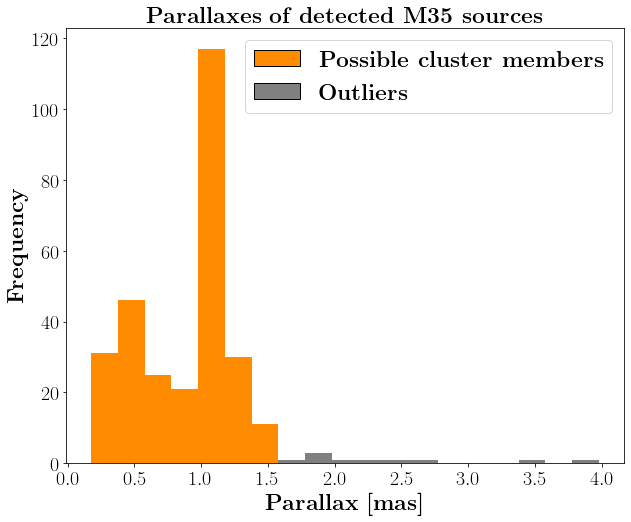

In [17]:
from astropy.io.votable import parse
import pandas as pd
from matplotlib.patches import Rectangle

def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

d = votable_to_pandas('parallaxes_M35_1sec.vot')
d['parallax_error_percentage'] = d['parallax_error']/d['parallax']

parallax_real = d.loc[(d['parallax']>0) & (d['parallax_error_percentage']< 0.1)]


parallax_restricted = parallax_real[parallax_real['parallax']<min(parallax_real['parallax'])+1.4]

parallax = np.mean(parallax_restricted['parallax'])
parallax_std = np.std(parallax_restricted['parallax'])
parallax_number = len(parallax_restricted['parallax'])

d1 = votable_to_pandas('parallaxes_M35_1sec.vot')
parallax1 = np.mean(d1['parallax'])
plt.figure(figsize=[10,8])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=23)     # fontsize of the axes title
plt.rc('axes', labelsize=23)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=23)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
N, bins, patches = plt.hist(parallax_real['parallax'], bins=np.arange(min(parallax_real['parallax']), max(parallax_real['parallax']) + 0.2, 0.2))
#plt.hist(d1['parallax'], bins = 50)
plt.title(r'\textbf{Parallaxes of detected M35 sources}')
plt.xlabel(r'\textbf{Parallax [mas]}')
plt.ylabel(r'\textbf{Frequency}')


for i in range(0,7):
    patches[i].set_facecolor('darkorange')
for i in range(7,19):    
    patches[i].set_facecolor('gray')
    
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['darkorange','gray']]
labels= [r'\textbf{Possible cluster members}',r'\textbf{Outliers}']
plt.legend(handles, labels)

plt.savefig('histogram_M35.png')
#plt.plot()
distance = 1000/parallax
print (parallax_std)
print (distance - 1000/(parallax+ parallax_std))
print (distance)
print (parallax)
print (d['parallax'])

Use parallax isntead of parallax1

In [18]:
isocmd = read_mist_models.ISOCMD('MIST_iso_604a1d34154e3.iso.cmd')

print ('version: ', isocmd.version)
print ('photometric system: ', isocmd.photo_sys)
print ('abundances: ', isocmd.abun)
print ('rotation: ', isocmd.rot)
print ('ages: ', [round(x,2) for x in isocmd.ages])
print ('number of ages: ', isocmd.num_ages)
print ('available columns: ', isocmd.hdr_list)
print ('Av extinction: ', isocmd.Av_extinction)

Reading in: MIST_iso_604a1d34154e3.iso.cmd
version:  {'MIST': '1.2', 'MESA': '7503'}
photometric system:  SDSS (AB)
abundances:  {'Yinit': 0.2703, 'Zinit': 0.0142, '[Fe/H]': 0.0, '[a/Fe]': 0.0}
rotation:  0.4
ages:  [5.0, 5.05, 5.1, 5.15, 5.2, 5.25, 5.3, 5.35, 5.4, 5.45, 5.5, 5.55, 5.6, 5.65, 5.7, 5.75, 5.8, 5.85, 5.9, 5.95, 6.0, 6.05, 6.1, 6.15, 6.2, 6.25, 6.3, 6.35, 6.4, 6.45, 6.5, 6.55, 6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05, 7.1, 7.15, 7.2, 7.25, 7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7, 7.75, 7.8, 7.85, 7.9, 7.95, 8.0, 8.05, 8.1, 8.15, 8.2, 8.25, 8.3, 8.35, 8.4, 8.45, 8.5, 8.55, 8.6, 8.65, 8.7, 8.75, 8.8, 8.85, 8.9, 8.95, 9.0, 9.05, 9.1, 9.15, 9.2, 9.25, 9.3, 9.35, 9.4, 9.45, 9.5, 9.55, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25, 10.3]
number of ages:  107
available columns:  ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'SDSS_u', 'SDSS_g', 'SDSS_r',

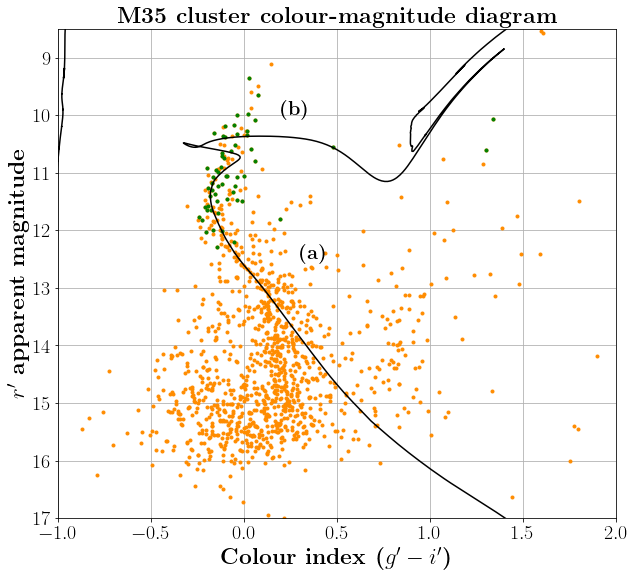

In [27]:
fig, ax = plt.subplots(figsize=(10, 9))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=23)     # fontsize of the axes title
plt.rc('axes', labelsize=23)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=23)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
age_ind = isocmd.age_index(8.95) # A guess at the cluster age, turning point, to be refined to fit data
G = isocmd.isocmds[age_ind]['SDSS_g']
R = isocmd.isocmds[age_ind]['SDSS_r']
I = isocmd.isocmds[age_ind]['SDSS_i']

ax.annotate(r'\textbf{(a)}', xy=(0.3, 12.5), xytext=(0.3, 12.5), fontsize=20)
ax.annotate(r'\textbf{(b)}', xy=(0.2, 10), xytext=(0.2, 10), fontsize=20)
plt.plot(gi, r_mag_corrected, ".", color="darkorange")
plt.plot(gi_callibration, r_mag_callibration, "g.")
plt.plot(G-I-0.06, R+9.9, "k") # the distance modulus mu=m-M, scales the isochrone data from absolute to apparant magnitude and thus gives distance, a guess to be refined to fit data
plt.xlim([-1, 3])
plt.xlabel(r'\textbf{Colour index ($g^\prime-i^\prime$)}')
plt.ylabel(r'\textbf{$r^\prime$ apparent magnitude}')
plt.title(r'\textbf{M35 cluster colour-magnitude diagram}')
plt.grid()
plt.axis([-1, 2, 17, 8.5])
plt.savefig("CMD_M35.png")

In [51]:
d_modulus = 10**(9.9/5 +1)
print (d_modulus)
print (10**8.9)

954.992586021436
794328234.7242821
